# Visual Inspection with AutoML Image Segmentation

## Necessary Imports & Config

In [ ]:
#@title Configuration & Parameters [RUN]
project_id = "sandbox-michael-menzel" #@param {type:"string"}
tfds_dataset = "oxford_iiit_pet:3.*.*" #@param {type:"string"}
target_folder = "examples/oxford" #@param {type:"string"}
target_bucket = "gs://visual-inspection-image-segmentation-sample-data-us-central1" #@param {type:"string"}
mask_ext = ".png" #@param {type:"string"}

!pip install --quiet backoff

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import matplotlib.pyplot as plt
import base64
import json
import os

tmp_target_folder = os.path.join('/tmp', target_folder)
service_account_name='automl-vision-segmentation-sa'
exts = [".png", ".jpg", ".jpeg"] # supported extensions
local_image_dir = os.path.join(tmp_target_folder, 'original')
local_mask_dir = os.path.join(tmp_target_folder, 'mask')
image_dir = os.path.join(target_bucket, target_folder, 'original')
mask_dir = os.path.join(target_bucket, target_folder, 'mask')
train_json = os.path.join(target_bucket, target_folder, 'automl.jsonl')

dataset, info = tfds.load(tfds_dataset, with_info=True, try_gcs=True, download_and_prepare_kwargs={'download_config': tfds.download.DownloadConfig(register_checksums = True)})
categories = ['background'] + info.features['label'].names
print(categories)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incomplete1IBWFC/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incomplete1IBWFC/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.
['background', 'Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [ ]:
#@title Mandatory Code [RUN]
import urllib.request
import urllib.error
import google.auth.transport.requests
import backoff
import matplotlib as mpl

BASE_URL = 'https://automl.googleapis.com/v1p1beta/'

def post_api(url, data):
    data = bytes(json.dumps(data).encode("utf-8"))
    req = urllib.request.Request(url, data, headers=get_headers())
    return decode_result(read_result(req))


def get_api(url):
    req = urllib.request.Request(url, headers=get_headers())
    return decode_result(read_result(req))

def delete_api(url):
    req = urllib.request.Request(url, headers=get_headers(), method='DELETE')
    return decode_result(read_result(req))

get_headers = lambda: {"Content-Type": "application/json", "Authorization": "Bearer %s" % get_token()}

def get_token():
    credentials.refresh(google.auth.transport.requests.Request())
    return credentials.token

read_result = lambda req: urllib.request.urlopen(req).read()
decode_result = lambda res: json.loads(res.decode("utf-8"))

def construct_url_from_full_operation(operation):
  return f"{BASE_URL}{operation}"

def construct_url_from_action(action):
  return f"{BASE_URL}projects/{project_id}/locations/us-central1/{action}"

@backoff.on_exception(backoff.fibo,
                      ValueError,
                      max_value=300,
                      max_time=12*60*60)
def automl_check_operation_status(operation):
  operation_result = get_api(construct_url_from_full_operation(operation))
  if 'done' in operation_result.keys() and operation_result['done']:
    if 'name' in operation_result['response'].keys():
      return operation_result['response']['name'].split('/')[-1]
    else:
      return operation_result
  else:
    raise ValueError

def automl_create_resource(action, data):
  resource_result = post_api(construct_url_from_action(action), data)
  return automl_check_operation_status(resource_result['name'])

def automl_predict_image_segmentation(model_id, image_url):
  with tf.io.gfile.GFile(image_url, "rb") as image_file:
      encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
      prediction_def = {
          "payload" : {
              "image": {
                  "imageBytes" : encoded_string
              },
          }
      }
      image = mpimg.imread(image_file, format='PNG')

  predicted = post_api(construct_url_from_action(f"models/{model_id}:predict"), prediction_def)
  
  mask_cat = base64.b64decode(predicted['payload'][0]['imageSegmentation']['categoryMask']['imageBytes'])
  mask_conf = base64.b64decode(predicted['payload'][0]['imageSegmentation']['confidenceMask']['imageBytes'])

  return image, decode_image(mask_cat), decode_image(mask_conf)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
import io

def decode_image(image_bytes):
  return mpimg.imread(io.BytesIO(image_bytes), format='PNG')

def plot_image_with_masks(image, category_mask, confidence_mask):
  fig, axes = plt.subplots(2, 3, figsize=(20, 10))

  axes.flat[0].imshow(image, cmap='gray')
  axes.flat[1].imshow(image, cmap='gray')
  axes.flat[1].imshow(category_mask, alpha=.5)
  plt_im_mask_cat = axes.flat[2].imshow(category_mask)
  axes.flat[3].imshow(image, cmap='gray')
  axes.flat[4].imshow(image, cmap='gray')
  axes.flat[4].imshow(confidence_mask, alpha=.5, cmap='coolwarm')
  axes.flat[5].imshow(confidence_mask, cmap='coolwarm')

  mask_values = np.unique(category_mask)
  mask_cmap_norm = mpl.colors.Normalize(vmin=np.min(mask_values),vmax=np.max(mask_values))
  colors = [plt_im_mask_cat.cmap(mask_cmap_norm(value)) for value in mask_values]
  patches = [mpatches.Patch(color=colors[i], label=f"{categories[value]}") for i, value in enumerate(mask_values)]
  axes.flat[2].legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))

  for ax in axes.flat:
    ax.axis('off') 
  plt.show()


## Authenticate

In [ ]:
#@title Run this code to authenticate & obtain credentials [RUN]
!gcloud config set project $project_id
import googleapiclient.discovery
from google.oauth2 import service_account

from google.colab import auth
auth.authenticate_user()
#user_name = !gcloud config get-value core/account

def get_credentials():
  try:
    return credentials
  except:
    return None

if not get_credentials():
  iam_service = googleapiclient.discovery.build('iam', 'v1', cache_discovery=False)

  # check if service account exists
  service_accounts = iam_service.projects().serviceAccounts().list(
          name=f"projects/{project_id}").execute()
  sa_name = f"{service_account_name}@{project_id}.iam.gserviceaccount.com"

  # create service account if it does not exists
  if not any(a['name'].split('/')[-1] == sa_name for a in service_accounts.get('accounts',[])):
    new_sa = iam_service.projects().serviceAccounts().create(
      name='projects/' + project_id,
      body={
        'accountId': service_account_name,
      }).execute()

    crm_service = googleapiclient.discovery.build("cloudresourcemanager", "v1", cache_discovery=False)
    roles = ['roles/storage.admin',
        'roles/bigquery.dataEditor',
        'roles/bigquery.user',
        'roles/automl.editor',
        'roles/logging.viewer']

    crm_policy = crm_service.projects().getIamPolicy(resource=project_id).execute()
    for role in roles:
      binding = {'role': role, 'members': [f"serviceAccount:{sa_name}"]}
      crm_policy["bindings"].append(binding)
    crm_policy = crm_service.projects().setIamPolicy(
      resource=project_id, body={"policy": crm_policy}).execute()

    print(f"Created service account: {new_sa['name']}")

  keys = iam_service.projects().serviceAccounts().keys().list(
      name=f"projects/{project_id}/serviceAccounts/{sa_name}",
      keyTypes='USER_MANAGED'
  ).execute()
  if 'keys' in keys.keys() and len(keys['keys']):
    for key in keys['keys']:
      iam_service.projects().serviceAccounts().keys().delete(
          name=key['name']
        ).execute()

  key = iam_service.projects().serviceAccounts().keys().create(
      name=f"projects/{project_id}/serviceAccounts/{sa_name}",
      body={'privateKeyType':'TYPE_GOOGLE_CREDENTIALS_FILE'}
    ).execute()

  credentials = service_account.Credentials.from_service_account_info(
      json.loads(base64.decodebytes(key['privateKeyData'].encode())),
      scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )

  print("service account authorized and credentials created")

Updated property [core/project].


service account authorized and credentials created


## Prepare Data

We load example data from the Oxford Pet public dataset.

In [ ]:
#@title Cleanup [OPTIONAL]
!rm -r $tmp_target_folder
!gsutil -m -q rm -r $target_bucket/$target_folder/*

In [ ]:
#generate an annotation dictionary
annotation_dict = [{'displayName': info.features['label'].names[i], 'category': i+1} for i in range(info.features['label'].num_classes)]
with tf.io.gfile.GFile(os.path.join(target_bucket, target_folder, 'annotation_dict.json'), 'w') as f:
    json.dump(annotation_dict, f)

#extract images from dataset
!mkdir -p $local_image_dir
!mkdir -p $local_mask_dir

def extract_images_from_datataset(dataset):
  from PIL import Image
  for i, sample in enumerate(dataset):
    label = sample['label'].numpy()
    label_name = info.features['label'].names[label]
    filename, ext = os.path.splitext(sample['file_name'].numpy().decode('utf-8'))
    image = sample['image'].numpy()
    image_out = f"{os.path.join(local_image_dir, filename)}.png"
    mask = sample['segmentation_mask'].numpy()
    mask[mask == 2] = 0
    mask[mask != 0] = label+1
    mask_out = f"{os.path.join(local_mask_dir, filename)}.png"
    
    if not tf.io.gfile.exists(image_out):
      tf.io.write_file(image_out, tf.image.encode_png(image))
    if not tf.io.gfile.exists(mask_out):
      tf.io.write_file(mask_out, tf.image.encode_png(mask))

    if i % 1000 == 0:
        print(f"Extracted {i} images.")

print('Extracting images...')
extract_images_from_datataset(dataset['train'])
extract_images_from_datataset(dataset['test'])
print('done.')

Extracting images...
Extracted 0 images.
Extracted 1000 images.
Extracted 2000 images.
Extracted 3000 images.
Extracted 0 images.
Extracted 1000 images.
Extracted 2000 images.
Extracted 3000 images.
done.


Let's upload the data to a Cloud Storage bucket.

In [ ]:
!echo 'Copying data to' $target_bucket/$target_folder
!gsutil -m -q cp -r $tmp_target_folder/* $target_bucket/$target_folder

Copying data to gs://visual-inspection-image-segmentation-sample-data-us-central1/examples/oxford


Finally, we need to generate a file list for AutoML which expects JSONL format.

In [ ]:
print('Collecting uploaded images...')

filelist = tf.io.gfile.listdir(image_dir)
valid_images_filelist = []
valid_masks_filelist = []
for filepath in filelist:
    filename, ext = os.path.splitext(filepath)
    if ext not in exts:
        print('This file is not supported for ISG training.')
        continue

    mask_filename = os.path.join(mask_dir, filename)
    mask_filepaths = lambda: (mask_filename + ext for ext in exts if tf.io.gfile.exists(mask_filename + ext))
    if not mask_ext and not any(mask_filepaths()):
        print(f"There is no mask for image: {filepath}.")
        continue

    mask_filepath = mask_filename + mask_ext if mask_ext else next(mask_filepaths())
    image_filepath = os.path.join(image_dir, filepath)

    valid_masks_filelist.append(mask_filepath)
    valid_images_filelist.append(image_filepath)
    if len(valid_images_filelist) % 1000 == 0:
        print("Collected %s images." % len(valid_images_filelist))

print('done.')

Collected 1000 images.
Collected 2000 images.
Collected 3000 images.
Collected 4000 images.
Collected 5000 images.
Collected 6000 images.
Collected 7000 images.
done.


In [ ]:
from io import StringIO
import random

num_of_images = len(valid_images_filelist)
test_num_threshold = int(num_of_images * 0.15)
val_num_threshold = int(num_of_images * 0.3)

content_buffer = StringIO()

training_lists = list(zip(valid_images_filelist, valid_masks_filelist))
random.shuffle(training_lists)
valid_images_filelist, valid_masks_filelist = zip(*training_lists)

tmpl = json.loads("""
{
    "mlUse": "YOUR_ML_USE",
    "imageExample": {
        "inputConfig": {
            "gcsSource": {
                "inputUris": ["YOUR_IMAGE_PATH"]
            }
        }
    },
    "categoryMask": {
        "inputConfig": {
            "gcsSource": {
                "inputUris": ["YOUR_LABEL_PATH"]
            }
        }
    },
    "annotationSpecs": [
        {
            "displayName": "YOUR_DISPLAY_NAME", 
            "category":1
        }
    ]
}
""")

for i in range(num_of_images):
    mluse = 'TRAIN'
    if i <= test_num_threshold:
        mluse = 'TEST'
    elif i <= val_num_threshold:
        mluse = 'VALIDATION'
    else:
        mluse = 'TRAIN'

    image_filepath = valid_images_filelist[i]
    mask_filepath = valid_masks_filelist[i]

    example = tmpl
    example['mlUse'] = mluse
    example['imageExample']['inputConfig']['gcsSource']['inputUris'] = [
        image_filepath
    ]
    example['categoryMask']['inputConfig']['gcsSource']['inputUris'] = [
        mask_filepath
    ]
    example['annotationSpecs'] = annotation_dict
    content_buffer.write(json.dumps(example))
    content_buffer.write('\n')

with tf.io.gfile.GFile(train_json, 'w') as f:
    f.write(content_buffer.getvalue())

## Train Model in AutoML Segmentation

### Clean Old Datasets & Models [OPTIONAL]

In [ ]:
get_api(construct_url_from_action("datasets"))

{'datasets': [{'createTime': '2020-04-17T13:21:07.557364Z',
   'displayName': 'oxford_test_v3',
   'etag': 'AB3BwFqF9LJ53rPtK8DRnVeyx5o1ZWk776jjP7Xe75RxSPBppxeH8d4aiuXuJSftvXat',
   'exampleCount': 7345,
   'imageSegmentationDatasetMetadata': {},
   'name': 'projects/928871478446/locations/us-central1/datasets/ISG7799458299396489216'},
  {'createTime': '2020-04-16T18:10:48.175349Z',
   'displayName': 'oxford_test_v2',
   'etag': 'AB3BwFqUwhi3PL5WlkJvZqbvlkuRtTTO6_xrOEb8vDE91oHVTCamcQ2LWG5NyLlTOMkP',
   'exampleCount': 7345,
   'imageSegmentationDatasetMetadata': {},
   'name': 'projects/928871478446/locations/us-central1/datasets/ISG7879678667759026176'},
  {'createTime': '2020-04-16T17:58:23.898897Z',
   'displayName': 'oxford_test_v2',
   'etag': 'AB3BwFofInuNt3SNU3AkAhlXIpp7PnWg6Fpq3VFyJZoIXFh3ITHsD1Q81L3AdRwd8gSS',
   'exampleCount': 7345,
   'imageSegmentationDatasetMetadata': {},
   'name': 'projects/928871478446/locations/us-central1/datasets/ISG1550995291396636672'},
  {'create

In [ ]:
for dataset in get_api(construct_url_from_action("datasets"))['datasets']:
    if 'imageSegmentationDatasetMetadata' in dataset.keys() and (not 'exampleCount' in dataset.keys() or not dataset['exampleCount']):
        print(f"deleting {dataset['name']}...")
        print(delete_api(construct_url_from_full_operation(dataset['name'])))

In [ ]:
get_api(construct_url_from_action("models"))

{'model': [{'createTime': '2020-04-18T11:25:57.222296Z',
   'datasetId': 'ISG5269983421186179072',
   'deploymentState': 'DEPLOYED',
   'displayName': 'pet_model_v5',
   'imageSegmentationModelMetadata': {'modelType': 'cloud-high-accuracy-1',
    'nodeCount': '1'},
   'name': 'projects/928871478446/locations/us-central1/models/ISG6586756347587461120',
   'updateTime': '2020-04-18T21:48:04.126273Z'},
  {'createTime': '2020-04-17T21:39:36.837927Z',
   'datasetId': 'ISG416369660275982336',
   'deploymentState': 'DEPLOYED',
   'displayName': 'pet_model_v4',
   'imageSegmentationModelMetadata': {'modelType': 'cloud-high-accuracy-1',
    'nodeCount': '1'},
   'name': 'projects/928871478446/locations/us-central1/models/ISG7481565298550636544',
   'updateTime': '2020-04-18T09:08:40.242650Z'},
  {'createTime': '2020-04-17T14:37:32.124801Z',
   'datasetId': 'ISG7799458299396489216',
   'deploymentState': 'DEPLOYED',
   'displayName': 'pet_model_v2',
   'imageSegmentationModelMetadata': {'modelTy

### Create Dataset

In [ ]:
dataset_def = {"displayName": "oxford_test_v5", "imageSegmentationDatasetMetadata": {}}
dataset_id = automl_create_resource('datasets', dataset_def)
print(f"Created dataset with id {dataset_id}.")

INFO:backoff:Backing off automl_check_operation_status(...) for 0.3s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 0.3s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 0.9s (ValueError)


Created dataset with id ISG5269983421186179072.


In [ ]:
dataimport_def = {
    "input_config": {
        "gcs_source": {
            "input_uris": [train_json]
        } 
    }
}
dataset_imported = automl_create_resource(f"datasets/{dataset_id}:importData", dataimport_def)
print(f"Imported data to dataset with id {dataset_id}.")

INFO:backoff:Backing off automl_check_operation_status(...) for 0.0s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 0.1s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 1.2s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 1.5s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 1.2s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 5.3s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 6.1s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 3.7s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 7.4s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 53.5s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 25.6s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 75.5s (ValueError)
INFO:backoff:

Imported data to dataset with id ISG5269983421186179072.


### Create Model

In [ ]:
model_def = {
    "displayName": "pet_model_v5",
    "datasetId": dataset_id,
    "imageSegmentationModelMetadata": {}
}
model_id = automl_create_resource('models', model_def)
print(f"Created model with id {model_id}.")

INFO:backoff:Backing off automl_check_operation_status(...) for 0.2s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 0.9s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 1.8s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 1.0s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 0.5s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 6.4s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 5.3s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 13.9s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 10.3s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 18.5s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 41.9s (ValueError)
INFO:backoff:Backing off automl_check_operation_status(...) for 60.9s (ValueError)
INFO:backof

### Evaluate Model

In [ ]:
get_api(construct_url_from_action(f"models/{model_id}/modelEvaluations"))

{'modelEvaluation': [{'annotationSpecId': '4514390234485489664',
   'createTime': '2020-04-18T21:37:30.764573Z',
   'imageSegmentationEvaluationMetrics': {'confidenceMetricsEntries': [{'confidenceThreshold': 0.3,
      'diceScoreCoefficient': 0.8742192,
      'iouScore': 0.77654475,
      'precision': 0.8974385,
      'recall': 0.85217106},
     {'confidenceThreshold': 0.2,
      'diceScoreCoefficient': 0.8766423,
      'iouScore': 0.7803768,
      'precision': 0.8919947,
      'recall': 0.8618094},
     {'confidenceThreshold': 0.4,
      'diceScoreCoefficient': 0.86598366,
      'iouScore': 0.76364297,
      'precision': 0.905663,
      'recall': 0.82963526},
     {'confidenceThreshold': 0.6,
      'diceScoreCoefficient': 0.84120584,
      'iouScore': 0.72593206,
      'precision': 0.9344181,
      'recall': 0.7649034},
     {'confidenceThreshold': 0.5,
      'diceScoreCoefficient': 0.85515034,
      'iouScore': 0.7469543,
      'precision': 0.91843504,
      'recall': 0.80002475},
  

### Deploy Model

In [ ]:
model_deployed = automl_create_resource(f"models/{model_id}:deploy", {})
print(f"Deployed model with id {model_id}.")

## Predict with AutoML Segmentation

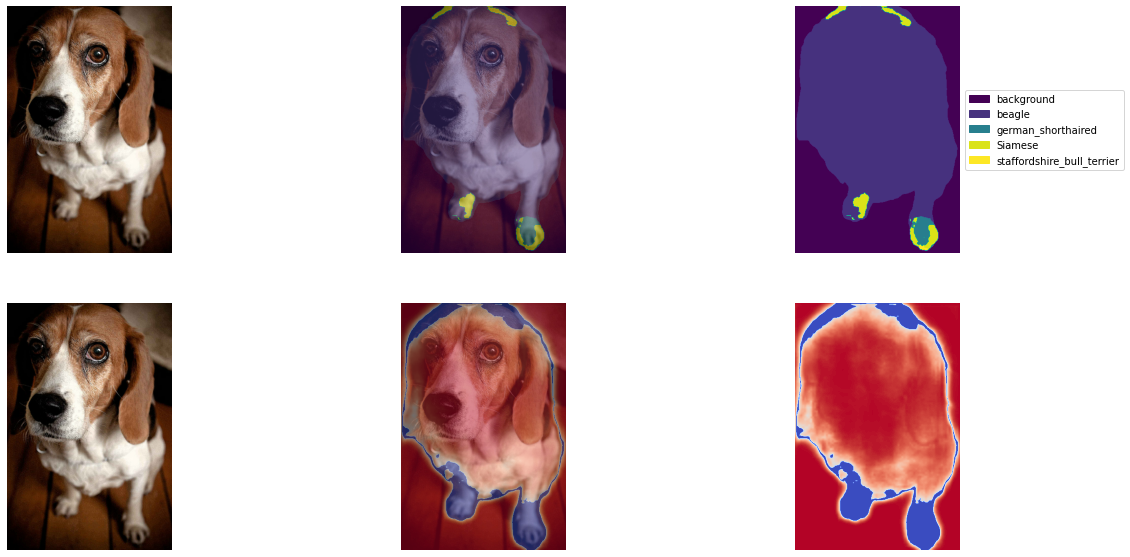

In [ ]:
model_id = 'ISG6586756347587461120'
test_image_url = f"{target_bucket}/examples/oxford/original/beagle_100.png"
test_image, mask_cat, mask_conf = automl_predict_image_segmentation(model_id, test_image_url)
plot_image_with_masks(test_image, mask_cat, mask_conf)